## Perceived Labor Income Risks and Asset Returns

- This notebook first downloads asset return indicators 
- Then we examine the correlation of higher moments of labor income risks and asset returns 

In [21]:
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import statsmodels.api as sm 
import scipy.stats as st  
from statsmodels.graphics import tsaplots as tsplt

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

###  1. Download stock return series 

In [3]:
## s&p 500 series 

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2019, 10, 30)

In [4]:
## downloading the data from Fred
sp500D= web.DataReader('sp500', 'fred', start, end)

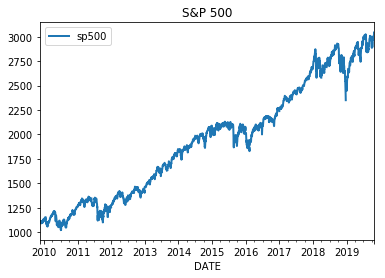

In [5]:
#plotting
sp500D.plot(lw=2)
sp500plt = plt.title('S&P 500')

In [6]:
## collapse to monthly data 
sp500D.index = pd.to_datetime(sp500D.index)
sp500M = sp500D.resample('M').last()

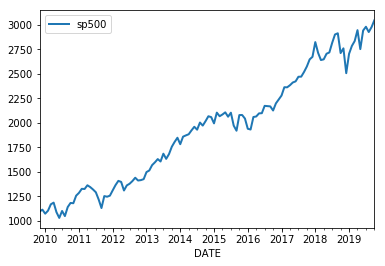

In [7]:
sp500M.plot(lw=2)
#sp500Mplt = plt.title('S&P 500 (end of month)')

In [8]:
sp500MR = np.log(sp500M).diff()

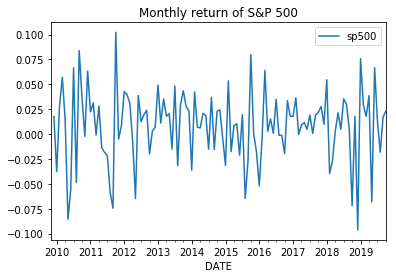

In [9]:
sp500MR.plot()
sp500MRplt = plt.title('Monthly return of S&P 500')

###  2. Loading and cleaning perceived income series 

In [10]:
## loading the stata file
SCEProbIndM = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')
SCEDstIndM = pd.read_stata('../SurveyData/SCE/IncExpSCEDstIndM.dta')

In [11]:
## subselect the dataframe
sub_var = ['date','userid','Q24_var','Q24_mean','Q24_iqr']
IncSCEIndMoms = SCEProbIndM[sub_var]
sub_var2 = ['date','userid','IncVar','IncMean','IncSkew','IncKurt']
IncSCEIndMomsEst = SCEDstIndM[sub_var2]

## drop nan observations
IncSCEIndMoms = IncSCEIndMoms.dropna(how='any')
IncSCEIndMomsEst = IncSCEIndMomsEst.dropna(how='any')


In [12]:
## deal with clusterring skewness value around zero first

IncSCEIndMomsEst['IncSkew'] = IncSCEIndMomsEst['IncSkew'].copy().replace(0,np.nan)

In [13]:
moms = ['Q24_mean','Q24_var','Q24_iqr']
moms_est = ['IncVar','IncMean','IncSkew','IncKurt']

## compute population summary stats for these ind moms
IncSCEPopMomsMed = pd.pivot_table(data = IncSCEIndMoms, 
                                  index=['date'], 
                                  values = moms,
                                  aggfunc= 'median').reset_index().rename(columns={'Q24_mean': 'meanMed', 
                                                                                   'Q24_var': 'varMed',
                                                                                  'Q24_iqr': 'iqrMed'})

IncSCEPopMomsMean = pd.pivot_table(data = IncSCEIndMoms, 
                                   index=['date'], 
                                  values = moms,
                                  aggfunc= 'mean').reset_index().rename(columns={'Q24_mean': 'meanMean',
                                                                                 'Q24_var': 'varMean',
                                                                                 'Q24_iqr': 'iqrMean'})

IncSCEPopMomsEstMed = pd.pivot_table(data = IncSCEIndMomsEst, 
                                     index=['date'],
                                     values = moms_est,
                                     aggfunc= 'median').reset_index().rename(columns={'IncMean': 'meanEstMed',
                                                                                      'IncVar': 'varEstMed',
                                                                                      'IncSkew': 'skewEstMed',
                                                                                      'IncKurt':'kurtEstMed'})

IncSCEPopMomsEstMean = pd.pivot_table(data = IncSCEIndMomsEst, 
                                      index=['date'],
                                      values = moms_est,
                                      aggfunc= 'mean').reset_index().rename(columns={'IncMean': 'meanEstMean',
                                                                                    'IncVar': 'varEstMean',
                                                                                    'IncSkew': 'skewEstMean',
                                                                                    'IncKurt':'kurtEstMean'})

In [14]:
## streamline the dates for merging 

# adjusting the end-of-month dates to the begining-of-month for combining 
sp500MR.index = sp500MR.index.shift(1,freq='D') 

IncSCEPopMomsMed.index = pd.DatetimeIndex(IncSCEPopMomsMed['date'] ,freq='infer')
IncSCEPopMomsMean.index = pd.DatetimeIndex(IncSCEPopMomsMean['date'] ,freq='infer')
IncSCEPopMomsEstMed.index = pd.DatetimeIndex(IncSCEPopMomsEstMed['date'] ,freq='infer')
IncSCEPopMomsEstMean.index = pd.DatetimeIndex(IncSCEPopMomsEstMean['date'] ,freq='infer')

### 3. Combinine the two series 

In [15]:
dt_combM = pd.concat([sp500MR,
                      IncSCEPopMomsMed,
                      IncSCEPopMomsMean,
                      IncSCEPopMomsEstMed,
                      IncSCEPopMomsEstMean],
                     join="inner",axis=1).drop(columns=['date'])

In [16]:
dt_combM.tail()

,sp500,iqrMed,meanMed,varMed,iqrMean,meanMean,varMean,kurtEstMed,meanEstMed,skewEstMed,varEstMed,kurtEstMean,meanEstMean,skewEstMean,varEstMean
2018-01-01,0.01,1.30,2.73,0.88,2.21,2.98,4.04,-0.60,1.00,0.19,0.33,-0.45,1.88,0.10,0.49
2018-02-01,0.05,1.17,2.83,0.70,2.25,3.08,4.23,-0.60,1.00,0.16,0.33,-0.51,1.84,0.12,0.48
2018-03-01,-0.04,1.17,2.70,0.67,2.12,2.95,3.81,-0.60,1.00,0.18,0.33,-0.51,1.92,0.14,0.49
2018-04-01,-0.03,1.17,2.83,0.71,2.07,3.05,3.42,-0.60,1.00,0.20,0.33,-0.46,1.81,0.17,0.46
2018-05-01,0.00,1.17,2.83,0.71,2.19,3.08,3.86,-0.60,1.00,0.20,0.33,-0.47,1.74,0.16,0.45


### 4. Seasonal adjustment (not successful yet)

In [18]:
to_sa_test = ['meanMed']
to_sa_list = list(dt_combM.columns.drop('sp500'))

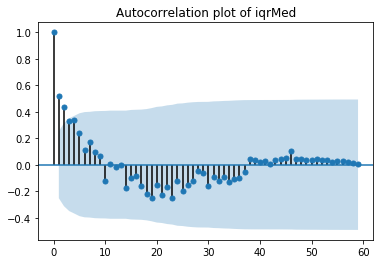

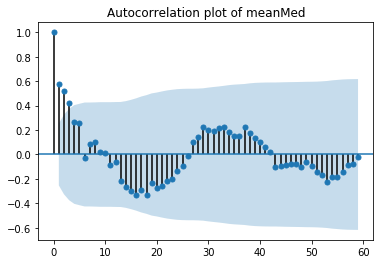

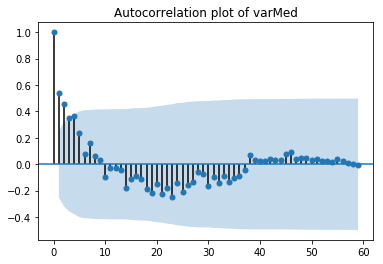

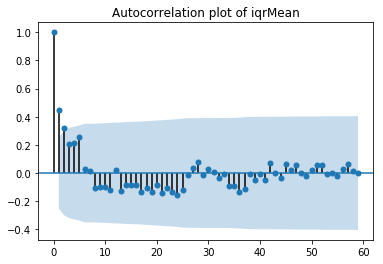

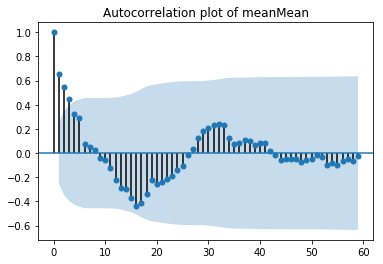

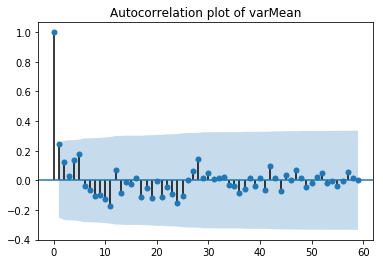

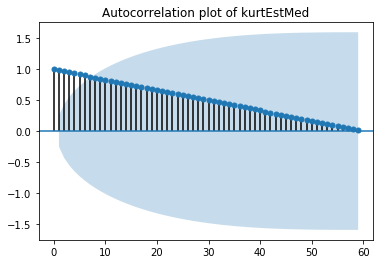

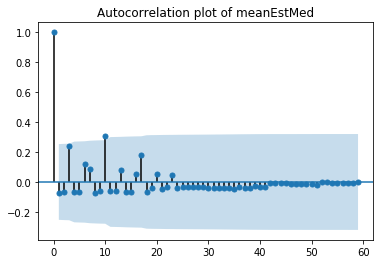

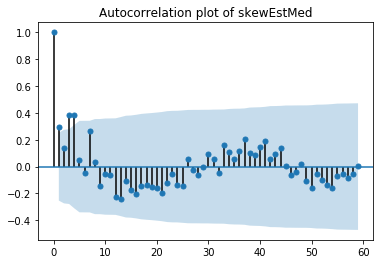

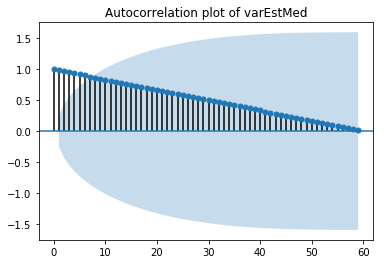

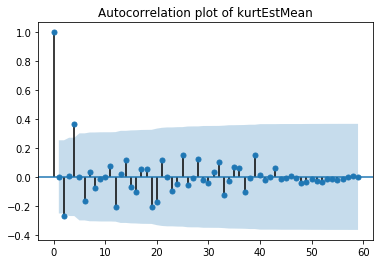

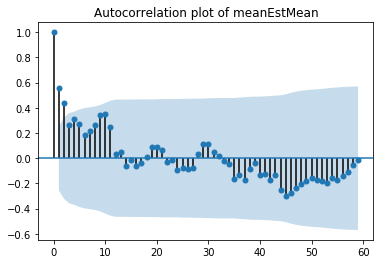

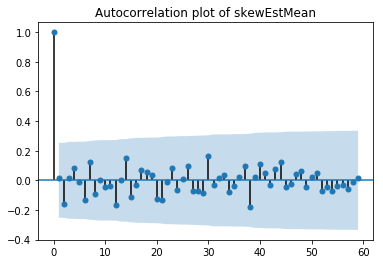

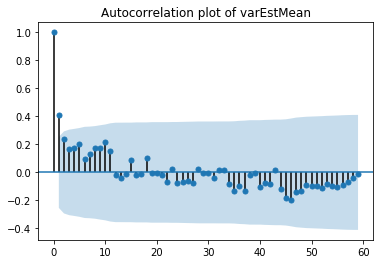

In [25]:
## inspect for seasonal pattern by looking into the autocovariance

for sr in to_sa_list:
    tsplt.plot_acf(dt_combM[sr])
    plt.title('Autocorrelation plot of '+sr)

In [97]:
for sr in to_sa_test:
    series = dt_combM[sr]
    samodel = sm.tsa.UnobservedComponents(series,
                                          level='fixed intercept',
                                          seasonal = 12)
    res = samodel.fit(disp = True)
    print(res.summary())
    #res_plt = res.plot_components(figsize=(4,11))
    #plt.plot(res.level.filtered)

                            Unobserved Components Results                            
Dep. Variable:                       meanMed   No. Observations:                   60
Model:                       fixed intercept   Log Likelihood                 -78.241
                   + stochastic seasonal(12)   AIC                            158.482
Date:                       Tue, 12 Nov 2019   BIC                            160.353
Time:                               21:33:09   HQIC                           159.189
Sample:                           06-01-2013                                         
                                - 05-01-2018                                         
Covariance Type:                         opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.seasonal     1.4064      0.372      3.783      0.00

### 5. Correlation and times series patterns 

In [98]:
dt_combM.corr()

,sp500,iqrMed,meanMed,varMed,iqrMean,meanMean,varMean,kurtEstMed,meanEstMed,skewEstMed,varEstMed,kurtEstMean,meanEstMean,skewEstMean,varEstMean
sp500,1.00,0.03,0.07,0.04,0.21,0.02,0.24,-0.00,0.01,-0.03,0.00,-0.00,-0.13,-0.02,-0.12
iqrMed,0.03,1.00,0.54,0.98,0.68,0.62,0.55,-0.00,-0.15,0.37,-0.00,-0.09,0.07,0.13,-0.13
meanMed,0.07,0.54,1.00,0.58,0.56,0.89,0.49,-0.00,-0.02,0.60,-0.00,-0.21,0.49,0.24,0.29
varMed,0.04,0.98,0.58,1.00,0.71,0.65,0.57,-0.00,-0.15,0.40,-0.00,-0.09,0.08,0.15,-0.12
iqrMean,0.21,0.68,0.56,0.71,1.00,0.67,0.95,-0.00,-0.20,0.32,-0.00,-0.21,0.02,0.11,-0.08
meanMean,0.02,0.62,0.89,0.65,0.67,1.00,0.55,0.00,-0.03,0.60,0.00,-0.21,0.43,0.26,0.24
varMean,0.24,0.55,0.49,0.57,0.95,0.55,1.00,-0.00,-0.18,0.22,-0.00,-0.21,0.02,0.04,-0.04
kurtEstMed,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,1.00,0.00,0.00,1.00,-0.00,0.00,0.00,0.00
meanEstMed,0.01,-0.15,-0.02,-0.15,-0.20,-0.03,-0.18,0.00,1.00,0.19,0.00,0.10,0.24,0.15,0.20
skewEstMed,-0.03,0.37,0.60,0.40,0.32,0.60,0.22,0.00,0.19,1.00,0.00,-0.01,0.36,0.71,0.25


Correlation coefficient is 0.067, p-value is 0.611
Correlation coefficient is 0.038, p-value is 0.771
Correlation coefficient is 0.027, p-value is 0.835
Correlation coefficient is 0.013, p-value is 0.921
Correlation coefficient is 0.0, p-value is 1.0
Correlation coefficient is -0.025, p-value is 0.85
Correlation coefficient is 0.0, p-value is 1.0


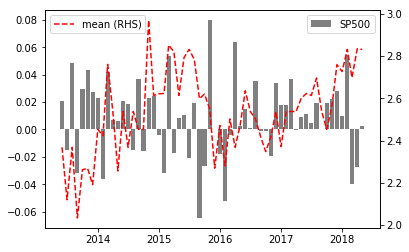

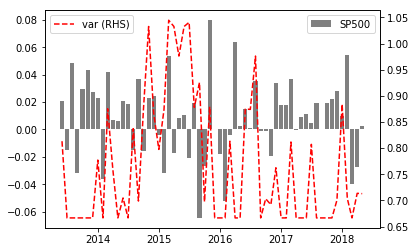

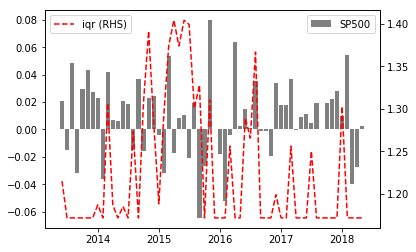

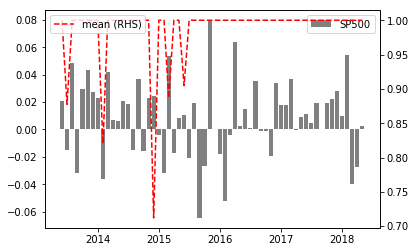

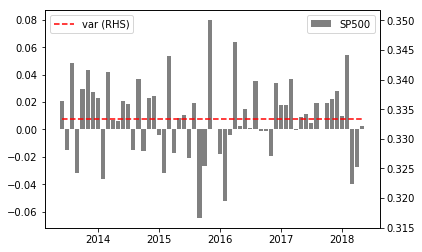

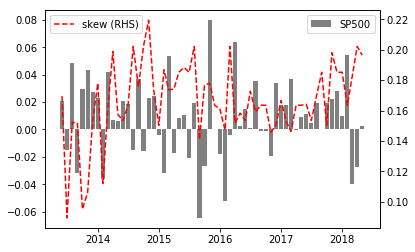

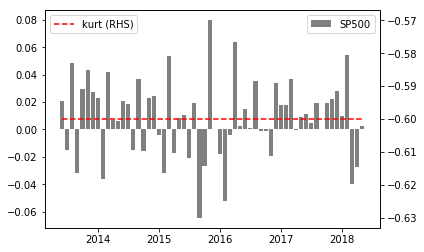

In [99]:
## plots of correlation for MEDIAN population stats 

for i,moms in enumerate( ['mean','var','iqr']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM[str(moms)+'Med'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    cor,pval =st.pearsonr(np.array(dt_combM['sp500']),
                          np.array(dt_combM[str(moms)+'Med']))
    print('Correlation coefficient is '+str(round(cor,3)) + ', p-value is '+ str(round(pval,3)))
    
for i,moms in enumerate( ['mean','var','skew','kurt']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM[str(moms)+'EstMed'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    cor,pval =st.pearsonr(np.array(dt_combM['sp500']),
                          np.array(dt_combM[str(moms)+'EstMed']))
    print('Correlation coefficient is '+str(round(cor,3)) + ', p-value is '+ str(round(pval,3)))

Correlation coefficient is 0.023, p-value is 0.859
Correlation coefficient is 0.238, p-value is 0.067
Correlation coefficient is 0.206, p-value is 0.115
Correlation coefficient is -0.127, p-value is 0.333
Correlation coefficient is -0.118, p-value is 0.368
Correlation coefficient is -0.023, p-value is 0.861
Correlation coefficient is -0.001, p-value is 0.995


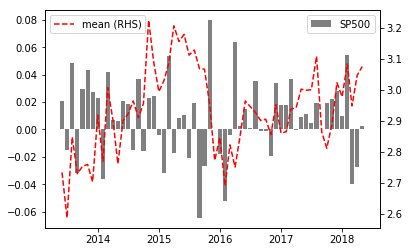

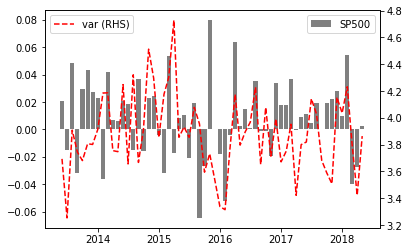

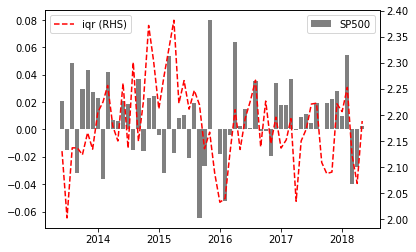

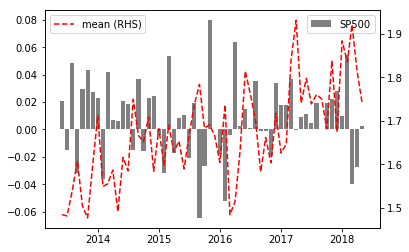

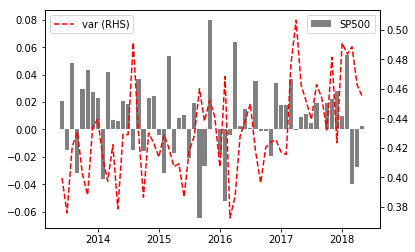

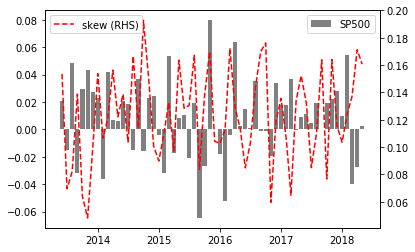

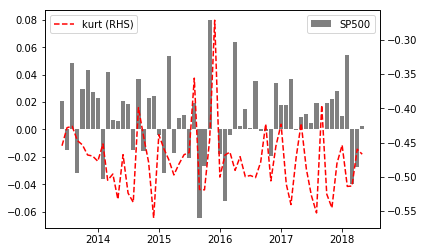

In [100]:
## plots of correlation for Mean population stats 

for i,moms in enumerate( ['mean','var','iqr']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM[str(moms)+'Mean'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    cor,pval =st.pearsonr(np.array(dt_combM['sp500']),
                          np.array(dt_combM[str(moms)+'Mean']))
    print('Correlation coefficient is '+str(round(cor,3)) + ', p-value is '+ str(round(pval,3)))
    
for i,moms in enumerate( ['mean','var','skew','kurt']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM[str(moms)+'EstMean'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    cor,pval =st.pearsonr(np.array(dt_combM['sp500']),
                          np.array(dt_combM[str(moms)+'EstMean']))
    print('Correlation coefficient is '+str(round(cor,3) ) + ', p-value is '+ str(round(pval,3) ))

In [101]:
## moving average 

dt_combM3mv = dt_combM.rolling(3).mean()

In [102]:
dt_combM3mv.corr()

,sp500,iqrMed,meanMed,varMed,iqrMean,meanMean,varMean,kurtEstMed,meanEstMed,skewEstMed,varEstMed,kurtEstMean,meanEstMean,skewEstMean,varEstMean
sp500,1.00,-0.20,-0.23,-0.20,0.03,-0.25,0.13,0.00,0.09,-0.26,nan,-0.18,-0.13,-0.31,-0.07
iqrMed,-0.20,1.00,0.61,0.99,0.76,0.76,0.62,-0.00,-0.41,0.52,nan,0.03,0.01,0.28,-0.28
meanMed,-0.23,0.61,1.00,0.63,0.59,0.92,0.54,-0.00,-0.22,0.78,nan,-0.31,0.62,0.42,0.38
varMed,-0.20,0.99,0.63,1.00,0.80,0.77,0.66,-0.00,-0.45,0.52,nan,0.01,0.01,0.27,-0.28
iqrMean,0.03,0.76,0.59,0.80,1.00,0.72,0.96,0.00,-0.52,0.45,nan,-0.29,-0.02,0.22,-0.24
meanMean,-0.25,0.76,0.92,0.77,0.72,1.00,0.62,-0.00,-0.28,0.71,nan,-0.21,0.49,0.40,0.23
varMean,0.13,0.62,0.54,0.66,0.96,0.62,1.00,0.00,-0.50,0.36,nan,-0.38,-0.00,0.15,-0.18
kurtEstMed,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,1.00,0.00,0.00,nan,0.00,0.00,0.00,0.00
meanEstMed,0.09,-0.41,-0.22,-0.45,-0.52,-0.28,-0.50,0.00,1.00,-0.11,nan,-0.00,0.29,0.05,0.35
skewEstMed,-0.26,0.52,0.78,0.52,0.45,0.71,0.36,0.00,-0.11,1.00,nan,-0.19,0.45,0.74,0.25


Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0


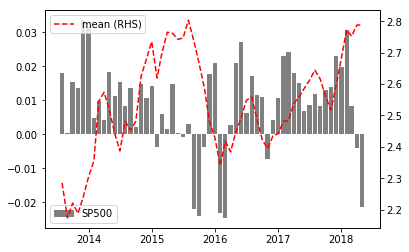

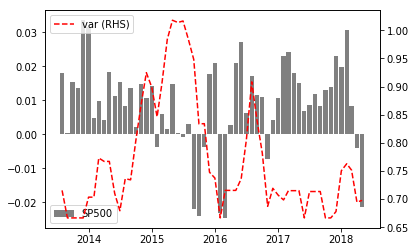

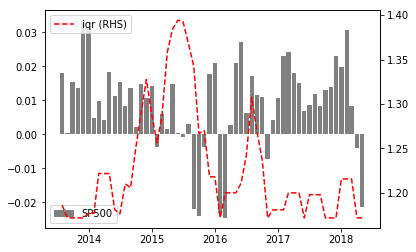

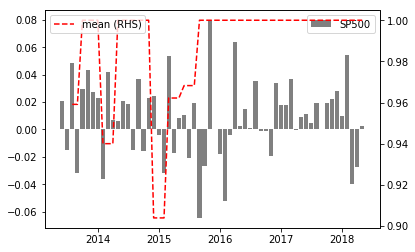

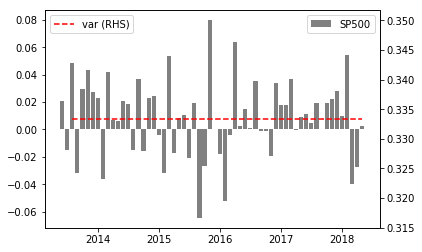

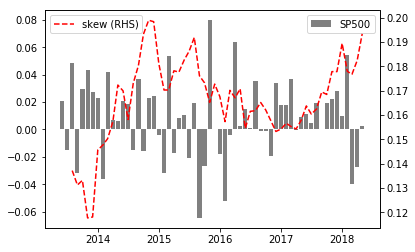

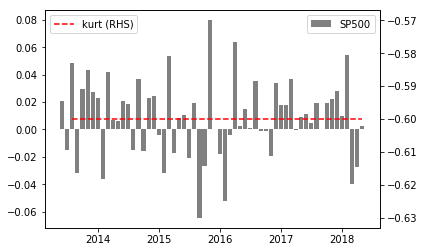

In [103]:
## plots of correlation for 3-month moving MEDIAN average 

for i,moms in enumerate( ['mean','var','iqr']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM3mv.index, dt_combM3mv['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM3mv[str(moms)+'Med'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    cor,pval = st.pearsonr(np.array(dt_combM3mv['sp500']),
                          np.array(dt_combM3mv[str(moms)+'Med']))
    print('Correlation coefficient is '+str(cor) + ', p-value is '+ str(pval))

for i,moms in enumerate( ['mean','var','skew','kurt']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM3mv.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM3mv[str(moms)+'EstMed'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    cor,pval =st.pearsonr(np.array(dt_combM3mv['sp500']),
                          np.array(dt_combM3mv[str(moms)+'EstMed']))
    print('Correlation coefficient is '+str(round(cor,3) ) + ', p-value is '+ str(round(pval,3) ))

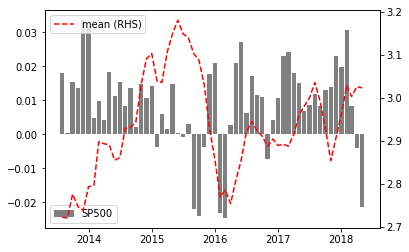

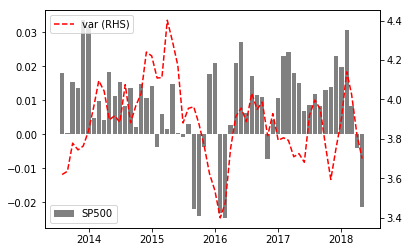

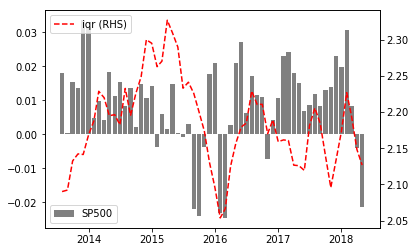

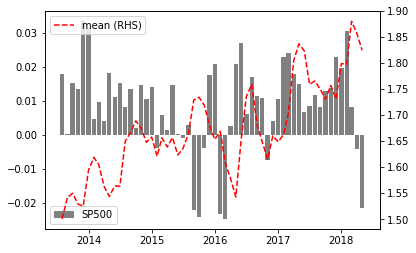

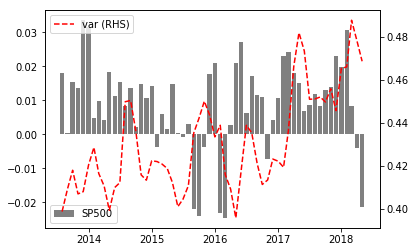

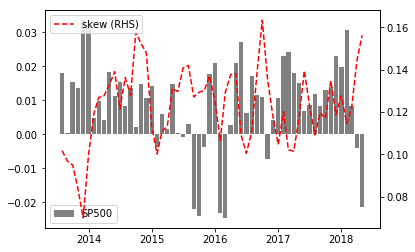

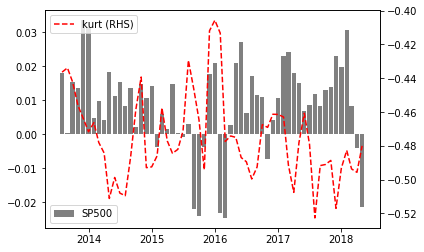

In [104]:
## plots of correlation for 3-month moving mean average 

for i,moms in enumerate( ['mean','var','iqr']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM3mv.index, dt_combM3mv['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM3mv[str(moms)+'Mean'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    #cor,pval =st.pearsonr(np.array(dt_combM['sp500']),
    #                      np.array(dt_combM3mv[str(moms)+'Mean']))
    #print('Correlation coefficient is '+str(cor) + ', p-value is '+ str(pval))
    
    
for i,moms in enumerate( ['mean','var','skew','kurt']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM3mv.index, dt_combM3mv['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM3mv[str(moms)+'EstMean'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    #cor,pval =st.pearsonr(np.array(dt_combM['sp500']),
    #                      np.array(dt_combM3mv[str(moms)+'EstMean']))
    #print('Correlation coefficient is '+str(cor) + ', p-value is '+ str(pval))